In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
cleaned_df = pd.read_csv('/content/drive/MyDrive/cleaned_mbti.csv')
cleaned_df.head()


,Unnamed: 0,type,plain_text
0,0,INFJ,and intj moments sportscenter not top ten...
1,1,ENTP,i m finding the lack of me in these posts ver...
2,2,INTP,good one course to which i say i k...
3,3,INTJ,dear intp i enjoyed our conversation the o...
4,4,ENTJ,you re fired that s another silly misconcept...


In [ ]:
cleaned_df.columns

Index(['Unnamed: 0', 'type', 'plain_text'], dtype='object')

In [ ]:
cleaned_df = cleaned_df.drop(columns=['Unnamed: 0'])

In [ ]:
cleaned_df.head()

,type,plain_text
0,INFJ,and intj moments sportscenter not top ten...
1,ENTP,i m finding the lack of me in these posts ver...
2,INTP,good one course to which i say i k...
3,INTJ,dear intp i enjoyed our conversation the o...
4,ENTJ,you re fired that s another silly misconcept...


In [ ]:
type_df = cleaned_df[['type','plain_text']].copy();

type_df['EI'] = type_df['type'].str.extract('(.)[N,S]',1)
type_df['NS'] = type_df['type'].str.extract('[E,I](.)[F,T]',1)
type_df['TF'] = type_df['type'].str.extract('[N,S](.)[J,P]',1)
type_df['JP'] = type_df['type'].str.extract('[F,T](.)',1)

type_df.head()

,type,plain_text,EI,NS,TF,JP
0,INFJ,and intj moments sportscenter not top ten...,I,N,F,J
1,ENTP,i m finding the lack of me in these posts ver...,E,N,T,P
2,INTP,good one course to which i say i k...,I,N,T,P
3,INTJ,dear intp i enjoyed our conversation the o...,I,N,T,J
4,ENTJ,you re fired that s another silly misconcept...,E,N,T,J


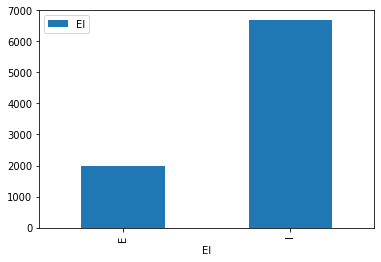

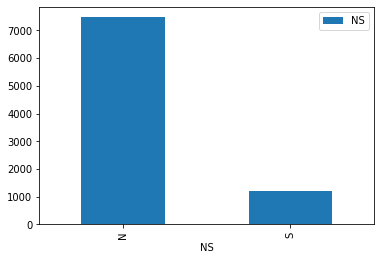

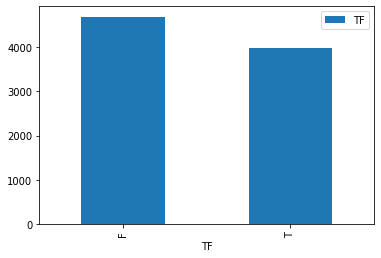

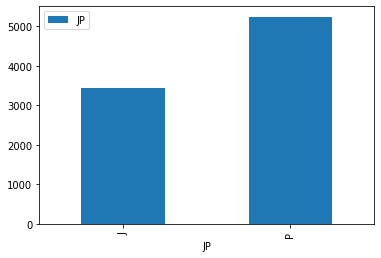

In [ ]:
type_df.groupby('EI').agg({'EI':'count'}).plot(kind="bar")
type_df.groupby('NS').agg({'NS':'count'}).plot(kind="bar")
type_df.groupby('TF').agg({'TF':'count'}).plot(kind="bar")
type_df.groupby('JP').agg({'JP':'count'}).plot(kind="bar")

In [ ]:
le = LabelEncoder()

encoded_df = cleaned_df[['type','plain_text']].copy()
encoded_df['E0-I1'] = le.fit_transform(type_df['EI'])
encoded_df['N0-S1'] = le.fit_transform(type_df['NS'])
encoded_df['F0-T1'] = le.fit_transform(type_df['TF'])
encoded_df['J0-P1'] = le.fit_transform(type_df['JP'])

encoded_df.head()

,type,plain_text,E0-I1,N0-S1,F0-T1,J0-P1
0,INFJ,and intj moments sportscenter not top ten...,1,0,0,0
1,ENTP,i m finding the lack of me in these posts ver...,0,0,1,1
2,INTP,good one course to which i say i k...,1,0,1,1
3,INTJ,dear intp i enjoyed our conversation the o...,1,0,1,0
4,ENTJ,you re fired that s another silly misconcept...,0,0,1,0


In [ ]:
X = encoded_df['plain_text'].values
Y = encoded_df.drop(columns=['type','plain_text'])

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42) 

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=17000,
    min_df=7,
    max_df=0.8,
    stop_words='english',
    ngram_range = (1,3)
)

In [ ]:
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.fit_transform(x_test)

In [ ]:
pickle.dump(vectorizer, open("/content/drive/MyDrive/vectorizer.pkl","wb"))

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_classifier =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=120)

## E-I Model

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2)

y_EI_train = y_train['E0-I1']
y_EI_test = y_test['E0-I1']

x_resampled_ros, y_EI_resampled_ros = ros.fit_resample(x_train, y_EI_train)

from collections import Counter
Counter(y_EI_resampled_ros)

Counter({0: 4980, 1: 4980})

In [ ]:
lr_classifier.fit(x_resampled_ros, y_EI_resampled_ros)

LogisticRegression(multi_class='ovr', n_jobs=1, random_state=1)

In [ ]:
rf_classifier.fit(x_resampled_ros, y_EI_resampled_ros)

RandomForestClassifier(n_estimators=120)

In [ ]:
y_EI_pred_lr = lr_classifier.predict(x_test)
y_EI_pred_rf = rf_classifier.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(f" Logistic regression model accuracy for E-I: {accuracy_score(y_EI_test, y_EI_pred_lr):.3f}")
print(f" Random Forest model accuracy for E-I: {accuracy_score(y_EI_test, y_EI_pred_rf):.3f}")


 Logistic regression model accuracy for E-I: 0.769
 Random Forest model accuracy for E-I: 0.775


In [ ]:
import pickle
pickle.dump(rf_classifier, open("/content/drive/MyDrive/model_EI.pkl","wb"))

## N-S Model

In [ ]:
y_NS_train = y_train['N0-S1']
y_NS_test = y_test['N0-S1']

x_resampled_ros, y_NS_resampled_ros = ros.fit_resample(x_train, y_NS_train)

from collections import Counter
Counter(y_NS_resampled_ros)

Counter({0: 5616, 1: 5616})

In [ ]:
lr_classifier.fit(x_resampled_ros, y_NS_resampled_ros)

LogisticRegression(multi_class='ovr', n_jobs=1, random_state=1)

In [ ]:
rf_classifier.fit(x_resampled_ros, y_NS_resampled_ros)

RandomForestClassifier(n_estimators=120)

In [ ]:
y_NS_pred_lr = lr_classifier.predict(x_test)
y_NS_pred_rf = rf_classifier.predict(x_test)

In [ ]:
print(f" Logistic regression model accuracy for N-S: {accuracy_score(y_NS_test, y_NS_pred_lr):.3f}")
print(f" Random Forest model accuracy for N-S: {accuracy_score(y_NS_test, y_NS_pred_rf):.3f}")

 Logistic regression model accuracy for N-S: 0.813
 Random Forest model accuracy for N-S: 0.827


In [ ]:
pickle.dump(rf_classifier, open("/content/drive/MyDrive/model_NS.pkl","wb"))

## F-T Model

In [ ]:
y_FT_train = y_train['F0-T1']
y_FT_test = y_test['F0-T1']

x_resampled_ros, y_FT_resampled_ros = ros.fit_resample(x_train, y_FT_train)

from collections import Counter
Counter(y_FT_resampled_ros)

Counter({0: 3515, 1: 3515})

In [ ]:
lr_classifier.fit(x_resampled_ros, y_FT_resampled_ros)

LogisticRegression(multi_class='ovr', n_jobs=1, random_state=1)

In [ ]:
rf_classifier.fit(x_resampled_ros, y_FT_resampled_ros)

RandomForestClassifier(n_estimators=120)

In [ ]:
y_FT_pred_lr = lr_classifier.predict(x_test)
y_FT_pred_rf = rf_classifier.predict(x_test)

In [ ]:
print(f" Logistic regression model accuracy for F-T: {accuracy_score(y_FT_test, y_FT_pred_lr):.3f}")
print(f" Random Forest model accuracy for F-T: {accuracy_score(y_FT_test, y_FT_pred_rf):.3f}")

 Logistic regression model accuracy for F-T: 0.509
 Random Forest model accuracy for F-T: 0.581


In [ ]:
pickle.dump(rf_classifier, open("/content/drive/MyDrive/model_FT.pkl","wb"))

## J-P Model

In [ ]:
y_JP_train = y_train['J0-P1']
y_JP_test = y_test['J0-P1']

x_resampled_ros, y_JP_resampled_ros = ros.fit_resample(x_train, y_JP_train)

from collections import Counter
Counter(y_JP_resampled_ros)

Counter({0: 3914, 1: 3914})

In [ ]:
lr_classifier.fit(x_resampled_ros, y_JP_resampled_ros)

LogisticRegression(multi_class='ovr', n_jobs=1, random_state=1)

In [ ]:
rf_classifier.fit(x_resampled_ros, y_JP_resampled_ros)

RandomForestClassifier(n_estimators=120)

In [ ]:
y_JP_pred_lr = lr_classifier.predict(x_test)
y_JP_pred_rf = rf_classifier.predict(x_test)


In [ ]:
print(f" Logistic regression model accuracy for J-P: {accuracy_score(y_JP_test, y_JP_pred_lr):.3f}")
print(f" Random Forest model accuracy for J-P: {accuracy_score(y_JP_test, y_JP_pred_rf):.3f}")

 Logistic regression model accuracy for J-P: 0.571
 Random Forest model accuracy for J-P: 0.609


In [ ]:
pickle.dump(rf_classifier, open("/content/drive/MyDrive/model_JP.pkl","wb"))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

report_EI = classification_report(y_EI_test, y_EI_pred_rf)
print(f"Classification report for E0-I1 group:")
print(report_EI)
print(f"Accuracy score: {accuracy_score(y_EI_test, y_EI_pred_rf):.3f}")
print("--------------------------")

report_NS = classification_report(y_NS_test, y_NS_pred_rf)
print(f"Classification report for N0-S1 group:")
print(report_NS)
print(f"Accuracy score: {accuracy_score(y_NS_test, y_NS_pred_rf):.3f}")
print("--------------------------")

report_FT = classification_report(y_FT_test, y_FT_pred_rf)
print(f"Classification report for F0-T1 group:")
print(report_FT)
print(f"Accuracy score: {accuracy_score(y_FT_test, y_FT_pred_rf):.3f}")
print("--------------------------")

report_JP = classification_report(y_JP_test, y_JP_pred_rf)
print(f"Classification report for J0-P1 group:")
print(report_JP)
print(f"Accuracy score: {accuracy_score(y_JP_test, y_JP_pred_rf):.3f}")

Classification report for E0-I1 group:
              precision    recall  f1-score   support

           0       0.24      0.01      0.03       473
           1       0.78      0.99      0.87      1696

    accuracy                           0.78      2169
   macro avg       0.51      0.50      0.45      2169
weighted avg       0.66      0.78      0.69      2169

Accuracy score: 0.775
--------------------------
Classification report for N0-S1 group:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1862
           1       0.24      0.10      0.14       307

    accuracy                           0.83      2169
   macro avg       0.55      0.52      0.52      2169
weighted avg       0.78      0.83      0.80      2169

Accuracy score: 0.827
--------------------------
Classification report for F0-T1 group:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1179
           1       0.5